# Analysing the distance between marginal distributions after PCA for Ham10000 models trained with high capacity teacher

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import decomposition
import numpy as np
from scipy import stats
from scipy.spatial import distance
from statsmodels.stats.multitest import multipletests
np.set_printoptions(suppress=True,formatter={'float_kind': '{:f}'.format})
plt.rcParams['figure.dpi'] = 250

In [15]:
def create_pca(
        embeds_array: np.ndarray,
        model_df: pd.DataFrame
    ):
    
    # n -> number of samples
    # m -> number of features
    n, m = embeds_array.shape
    pca = decomposition.PCA(n_components=0.99, whiten=False)
    embeds_pca = pca.fit_transform(embeds_array)

    mu = pca.mean_
    U = pca.components_.T
    D = pca.singular_values_**2 / (n - 1)
    exp_var = pca.explained_variance_ratio_

    model_df['PCA 1'] = embeds_pca[:,0]
    model_df['PCA 2'] = embeds_pca[:,1]
    model_df['PCA 3'] = embeds_pca[:,2]
    model_df['PCA 4'] = embeds_pca[:,3]

    # Replace numerical labels with categorical
    model_df['Targets'] = model_df['Targets'].replace({0: 'No finding', 1: 'Other'})
    model_df['Sex'] = model_df['Sex'].replace({0: 'Male', 1: 'Female'})
    model_df['Age'] = model_df['Age'].replace({0: '<60', 1: '60+'})

In [16]:
from scipy.stats import gaussian_kde

def create_sim_table(
    df: pd.DataFrame,
):
    
    def js_simlarity(marginal, samples):
        df_female = samples[samples['Sex'] == 'Female']
        df_male = samples[samples['Sex'] == 'Male']
        df_young = samples[samples['Age'] == '<60']
        df_old = samples[samples['Age'] == '60+']
        df_no_fnd = samples[samples['Targets'] == 'No finding']
        df_other = samples[samples['Targets'] == 'Other']

        def get_js_distance(data_1, data_2):
            # Generate an array of 1000 values between the min and max of both datasets. This serve as the range over which PDFs will be estimated
            x = np.linspace(min(np.min(data_1), np.min(data_2)), max(np.max(data_1), np.max(data_2)), num=1000)

            # Compute Univariate Kernel Density Estimate for both datasets
            pdf1 = gaussian_kde(data_1)(x)
            pdf2 = gaussian_kde(data_2)(x)

            # Normalise
            pdf1 /= np.sum(pdf1)
            pdf2 /= np.sum(pdf2)

            # To avoid div by 0
            epsilon = 1e-10
            pdf1 += epsilon
            pdf2 += epsilon

            return distance.jensenshannon(pdf1, pdf2, base=2)

        sim_label = get_js_distance(df_no_fnd[marginal], df_other[marginal])
        sim_age = get_js_distance(df_young[marginal], df_old[marginal])
        sim_sex = get_js_distance(df_male[marginal], df_female[marginal])

        return [sim_label, sim_sex, sim_age]
    
    sim_pca1 = js_simlarity('PCA 1', df)
    sim_pca2 = js_simlarity('PCA 2', df)
    sim_pca3 = js_simlarity('PCA 3', df)
    sim_pca4 = js_simlarity('PCA 4', df)

    index = ['PCA 1', 'PCA 2', 'PCA 3', 'PCA 4']
    columns = ['label_dist', 'sex_dist', 'age_dist']
    df_sim = pd.DataFrame([sim_pca1, sim_pca2, sim_pca3, sim_pca4], index=index, columns=columns)

    return df_sim
    


In [17]:
MODEL_FEATURES = {
    'resnet18': 512,
    'resnet34': 512,
    'resnet50': 2048,
    'resnet101': 2048,
}
RANDOM_STATE = 42

# PCA Modes similarity before & after KD

In [20]:
def pca_comparison_data(
    model_dir: str,
    is_student: bool,
    is_kd: bool,
    is_teacher: bool,
    teacher_id: str = None,
):
    # Look for the folders that have 'sam1' in them

    # TODO: THIS WORKS ONLY FOR STUDENT MODELS BUT I THINK WE ONLY DO RANDOM WEIGHTED SAMPLING
    if is_student:
        folders = [f for f in os.listdir(model_dir) if 'sam1' in f and ('r18' in f or 'r34' in f)]
    else:
        folders = [f for f in os.listdir(model_dir) if 'sam1' in f]


    if is_teacher:
        folders = [f for f in folders if teacher_id in f]

    if is_kd:
        assert teacher_id is not None
        folders = [f for f in folders if teacher_id in f]

    # Go to each folder and load 'embeds.csv' and 'test_predictions.csv'
    data = []
    for folder in folders:
        df = pd.read_csv(f'{model_dir}/{folder}/test.csv')

        # Create PCA
        embeds_df = pd.read_csv(f'{model_dir}/{folder}/embeds.csv')
        embeds = np.array(embeds_df.iloc[:,0:MODEL_FEATURES[df['model_name'].iloc[0]]])

        create_pca(embeds, embeds_df)
        sim_df = create_sim_table(embeds_df)
        sim_df = sim_df.reset_index()
        sim_df = sim_df.rename(columns={'index': 'PCA'})

        sim_df['avg_subgroup_sim'] = (sim_df['sex_dist'] + sim_df['age_dist']) / 2
        sim_df['model_id'] = df['model_id'].iloc[0]
        sim_df['model_name'] = df['model_name'].iloc[0]
        sim_df['teacher_id'] = df['teacher_id'].iloc[0]
        sim_df['teacher_name'] = df['teacher_name'].iloc[0]

        data.append(sim_df)

    df = pd.concat(data)
    return df


In [24]:
no_female = pca_comparison_data(
    model_dir='../../results/ham10000_no_female/resnet',
    is_student = True,
    is_kd = False,
    is_teacher = False,
)
print(no_female.shape)
no_female_kd = pca_comparison_data(
    model_dir='../../results/ham10000_no_female/kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s42',
    is_teacher = False,
)
print(no_female_kd.shape)
no_female_feature = pca_comparison_data(
    model_dir='../../results/ham10000_no_female/kd-feature_rgb',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s42',
    is_teacher = False,
)
print(no_female_feature.shape)
no_female_attention = pca_comparison_data(
    model_dir='../../results/ham10000_no_female/attention_kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s42',
    is_teacher = False,
)
print(no_female_attention.shape)



no_old = pca_comparison_data(
    model_dir='../../results/ham10000_no_old/resnet',
    is_student = True,
    is_kd = False,
    is_teacher = False,
)
print(no_old.shape)
no_old_kd = pca_comparison_data(
    model_dir='../../results/ham10000_no_old/kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s42',
    is_teacher = False,
)
print(no_old_kd.shape)
no_old_feature = pca_comparison_data(
    model_dir='../../results/ham10000_no_old/kd-feature_rgb',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s42',
    is_teacher = False,
)
print(no_old_feature.shape)
no_old_attention = pca_comparison_data(
    model_dir='../../results/ham10000_no_old/attention_kd',
    is_student = True,
    is_kd = True,
    teacher_id='r101-sam1-s42',
    is_teacher = False,
)
print(no_old_attention.shape)


teacher_df = pca_comparison_data(
    model_dir='../../results/ham10000/resnet/original',
    is_student = False,
    is_kd = False,
    is_teacher = True,
    teacher_id='r101-sam1-s42',
)
print(teacher_df.shape)

(40, 9)
(40, 9)
(40, 9)
(40, 9)
(40, 9)
(40, 9)
(40, 9)
(40, 9)
(4, 9)


In [25]:
def plot_similarity_grouped_barplot(
    teacher_df: pd.DataFrame,
    students_df_kd: pd.DataFrame,
    students_df_feature: pd.DataFrame,
    students_df_attention: pd.DataFrame,
    metric: str,
    title: str = '',
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Prepare KD data
    before_kd = students_df_kd[pd.isna(students_df_kd['teacher_id'])]
    before_kd['label'] = 'Avg w/o KD'
    after_kd = students_df_kd[pd.notna(students_df_kd['teacher_id'])]
    after_kd['label'] = 'Avg w/ Vanilla KD'

    feature_after = students_df_feature[pd.notna(students_df_feature['teacher_id'])]
    feature_after['label'] = 'Avg w/ Feature KD'

    attention_after = students_df_attention[pd.notna(students_df_attention['teacher_id'])]
    attention_after['label'] = 'Avg w/ Attention KD'

    teacher_df['label'] = 'Teacher'

    # df = pd.concat([teacher_df, r18_before_kd, r18_after_kd, r34_before_kd, r34_after_kd])
    df = pd.concat([teacher_df, before_kd, after_kd, feature_after, attention_after])

    colors = ["salmon", "wheat", "sienna", "plum", "purple"]
    colors = ["salmon", "lightskyblue", "orange", "forestgreen", "purple"]

    # --------- only for display - not needed for the actual plot ------------

    df = df.drop(columns=['avg_subgroup_sim'])
    display_df = df.groupby(['PCA', 'label']).mean()
    display(display_df.round(3))


    def compute_difference(df, column):
        pivot_df = df.pivot_table(index='label', columns='PCA', values=column)
        diff_df = pivot_df.subtract(pivot_df.loc['Teacher'], axis=1)
        diff_df = diff_df.stack().reset_index(name=f'{column}_diff')
        diff_df = diff_df[diff_df['label'] != 'Teacher']
        return diff_df

    columns_to_diff = [col for col in display_df.columns if col not in ['PCA', 'label']]
    result_df = compute_difference(display_df, columns_to_diff[0])
    for col in columns_to_diff[1:]:
        diff_df = compute_difference(df, col)
        result_df = pd.merge(result_df, diff_df, on=['PCA', 'label'])
    result_df = result_df.set_index(['label', 'PCA'])
    display(result_df.round(3))


    g = sns.catplot(
        data=df, kind="bar",
        x="PCA", y=metric, hue="label", errorbar="sd", height=6, estimator=np.mean, aspect=1.5, capsize=0.05, errwidth=1.2, palette=colors,
    )

    g.ax.set_axisbelow(True)

    # Set the custom y-scale
    min_val = df[metric].min()
    max_val = df[metric].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))
    # plt.ylim(0, 0.2)

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')

    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)


    # Set titles
    plt.xlabel('')
    plt.title(title)

    # Move the legend outside and adjust its position
    # plt.tight_layout()  # Ensures the plot and legend do not overlap
    # legend.set_bbox_to_anchor((1.02, 0.5))  # Adjust the coordinates for desired positioning


    # Add a gap between bars in the same group
    for bar_container in g.ax.containers:
        for bar in bar_container:
            x = bar.get_x()
            width = bar.get_width()
            centre = x + width / 2.

            bar.set_x(centre - (0.8 * width / 2.))  # 0.9 controls the size of the gap; smaller values create a bigger gap
            bar.set_width(0.8 * width)  # The bar width is reduced to 90% to create the gap

    plt.rcParams['figure.dpi'] = 100
    plt.show()

### Plot

In [26]:
no_female['data'] = 'no female'
no_female_kd['data'] = 'no female'
no_female_feature['data'] = 'no female'
no_female_attention['data'] = 'no female'
no_old['data'] = 'no old'
no_old_kd['data'] = 'no old'
no_old_feature['data'] = 'no old'
no_old_attention['data'] = 'no old'

student_df = pd.concat([no_female, no_female_kd, no_old, no_old_kd,])
student_feature = pd.concat([no_female, no_female_feature, no_old, no_old_feature])
student_attention = pd.concat([no_female, no_female_attention, no_old, no_old_attention])

### All Unfair Datasets Averaged

/tmp/ipykernel_2942577/3828472836.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2942577/3828472836.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2942577/3828472836.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist
PCA   label                                              
PCA 1 Avg w/ Attention KD       0.629     0.097     0.370
      Avg w/ Feature KD         0.630     0.100     0.330
      Avg w/ Vanilla KD         0.634     0.103     0.365
      Avg w/o KD                0.611     0.090     0.352
      Teacher                   0.636     0.063     0.350
PCA 2 Avg w/ Attention KD       0.319     0.167     0.135
      Avg w/ Feature KD         0.374     0.172     0.175
      Avg w/ Vanilla KD         0.327     0.143     0.140
      Avg w/o KD                0.292     0.159     0.146
      Teacher                   0.339     0.215     0.159
PCA 3 Avg w/ Attention KD       0.229     0.134     0.128
      Avg w/ Feature KD         0.300     0.190     0.192
      Avg w/ Vanilla KD         0.202     0.140     0.181
      Avg w/o KD                0.223     0.169     0.152
      Teacher                   0.309     0.145     0.121
PCA 4 Avg w/ Attention KD       0.162     0.099     0.137
      Avg w/ Feature KD         0.172     0.089     0.179
      Avg w/ Vanilla KD         0.198     0.145     0.160
      Avg w/o KD                0.179     0.122     0.149
      Teacher                   0.206     0.107     0.170

label_dist_diff  sex_dist_diff  age_dist_diff
label               PCA                                                 
Avg w/ Attention KD PCA 1           -0.008          0.033          0.020
                    PCA 2           -0.020         -0.048         -0.024
                    PCA 3           -0.080         -0.011          0.007
                    PCA 4           -0.044         -0.008         -0.032
Avg w/ Feature KD   PCA 1           -0.006          0.037         -0.021
                    PCA 2            0.035         -0.043          0.016
                    PCA 3           -0.009          0.045          0.071
                    PCA 4           -0.034         -0.018          0.010
Avg w/ Vanilla KD   PCA 1           -0.003          0.039          0.015
                    PCA 2           -0.012         -0.072         -0.019
                    PCA 3           -0.107         -0.005          0.059
                    PCA 4           -0.008          0.038         -0.010
Avg w/o KD          PCA 1           -0.026          0.026          0.001
                    PCA 2           -0.047         -0.056         -0.013
                    PCA 3           -0.086          0.024          0.030
                    PCA 4           -0.028          0.015         -0.021

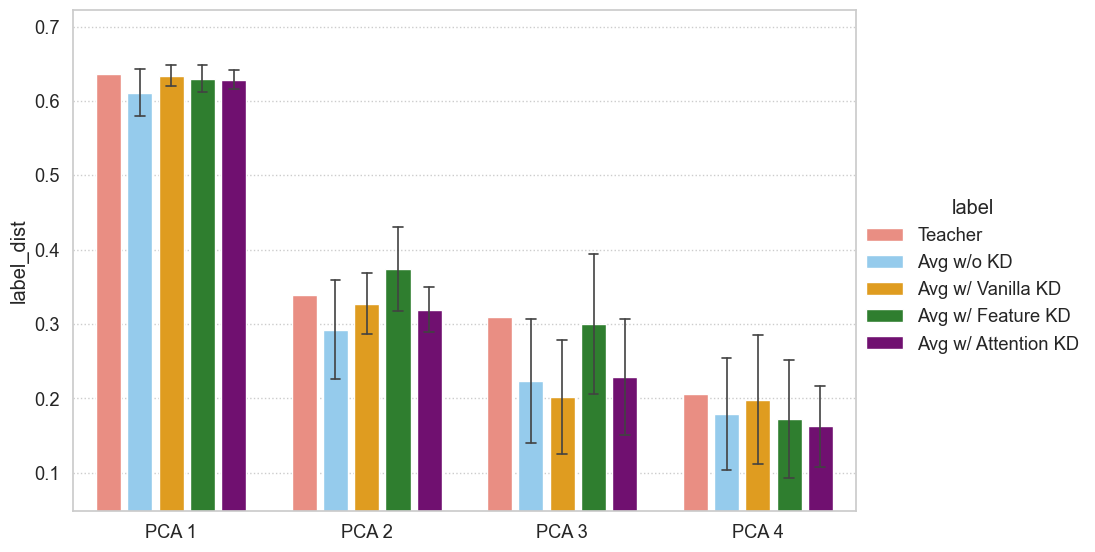

/tmp/ipykernel_2942577/3828472836.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2942577/3828472836.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2942577/3828472836.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist
PCA   label                                              
PCA 1 Avg w/ Attention KD       0.629     0.097     0.370
      Avg w/ Feature KD         0.630     0.100     0.330
      Avg w/ Vanilla KD         0.634     0.103     0.365
      Avg w/o KD                0.611     0.090     0.352
      Teacher                   0.636     0.063     0.350
PCA 2 Avg w/ Attention KD       0.319     0.167     0.135
      Avg w/ Feature KD         0.374     0.172     0.175
      Avg w/ Vanilla KD         0.327     0.143     0.140
      Avg w/o KD                0.292     0.159     0.146
      Teacher                   0.339     0.215     0.159
PCA 3 Avg w/ Attention KD       0.229     0.134     0.128
      Avg w/ Feature KD         0.300     0.190     0.192
      Avg w/ Vanilla KD         0.202     0.140     0.181
      Avg w/o KD                0.223     0.169     0.152
      Teacher                   0.309     0.145     0.121
PCA 4 Avg w/ Attention KD       0.162     0.099     0.137
      Avg w/ Feature KD         0.172     0.089     0.179
      Avg w/ Vanilla KD         0.198     0.145     0.160
      Avg w/o KD                0.179     0.122     0.149
      Teacher                   0.206     0.107     0.170

label_dist_diff  sex_dist_diff  age_dist_diff
label               PCA                                                 
Avg w/ Attention KD PCA 1           -0.008          0.033          0.020
                    PCA 2           -0.020         -0.048         -0.024
                    PCA 3           -0.080         -0.011          0.007
                    PCA 4           -0.044         -0.008         -0.032
Avg w/ Feature KD   PCA 1           -0.006          0.037         -0.021
                    PCA 2            0.035         -0.043          0.016
                    PCA 3           -0.009          0.045          0.071
                    PCA 4           -0.034         -0.018          0.010
Avg w/ Vanilla KD   PCA 1           -0.003          0.039          0.015
                    PCA 2           -0.012         -0.072         -0.019
                    PCA 3           -0.107         -0.005          0.059
                    PCA 4           -0.008          0.038         -0.010
Avg w/o KD          PCA 1           -0.026          0.026          0.001
                    PCA 2           -0.047         -0.056         -0.013
                    PCA 3           -0.086          0.024          0.030
                    PCA 4           -0.028          0.015         -0.021

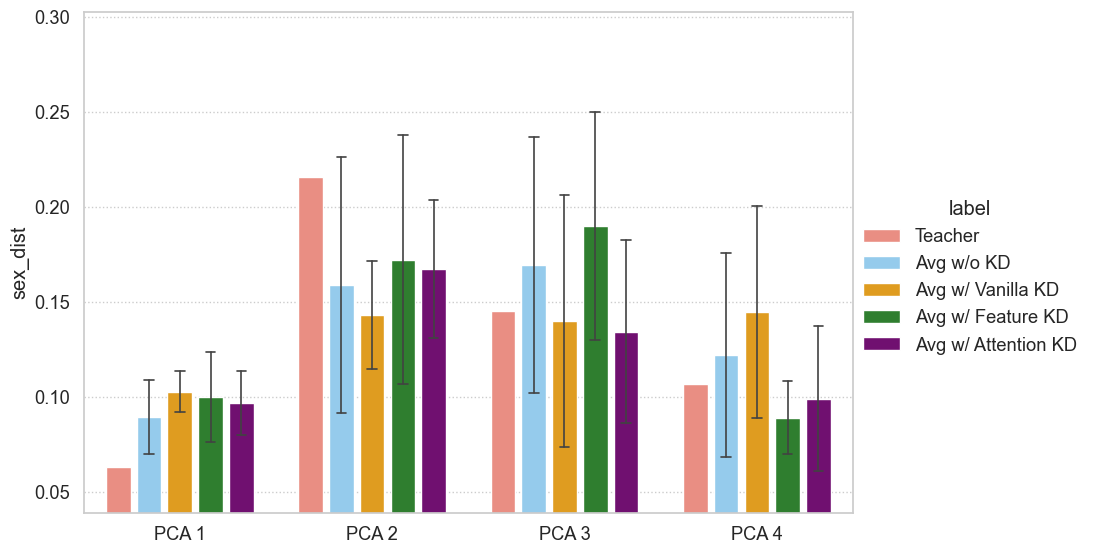

/tmp/ipykernel_2942577/3828472836.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_kd['label'] = 'Avg w/o KD'
/tmp/ipykernel_2942577/3828472836.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_kd['label'] = 'Avg w/ Vanilla KD'
/tmp/ipykernel_2942577/3828472836.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

label_dist  sex_dist  age_dist
PCA   label                                              
PCA 1 Avg w/ Attention KD       0.629     0.097     0.370
      Avg w/ Feature KD         0.630     0.100     0.330
      Avg w/ Vanilla KD         0.634     0.103     0.365
      Avg w/o KD                0.611     0.090     0.352
      Teacher                   0.636     0.063     0.350
PCA 2 Avg w/ Attention KD       0.319     0.167     0.135
      Avg w/ Feature KD         0.374     0.172     0.175
      Avg w/ Vanilla KD         0.327     0.143     0.140
      Avg w/o KD                0.292     0.159     0.146
      Teacher                   0.339     0.215     0.159
PCA 3 Avg w/ Attention KD       0.229     0.134     0.128
      Avg w/ Feature KD         0.300     0.190     0.192
      Avg w/ Vanilla KD         0.202     0.140     0.181
      Avg w/o KD                0.223     0.169     0.152
      Teacher                   0.309     0.145     0.121
PCA 4 Avg w/ Attention KD       0.162     0.099     0.137
      Avg w/ Feature KD         0.172     0.089     0.179
      Avg w/ Vanilla KD         0.198     0.145     0.160
      Avg w/o KD                0.179     0.122     0.149
      Teacher                   0.206     0.107     0.170

label_dist_diff  sex_dist_diff  age_dist_diff
label               PCA                                                 
Avg w/ Attention KD PCA 1           -0.008          0.033          0.020
                    PCA 2           -0.020         -0.048         -0.024
                    PCA 3           -0.080         -0.011          0.007
                    PCA 4           -0.044         -0.008         -0.032
Avg w/ Feature KD   PCA 1           -0.006          0.037         -0.021
                    PCA 2            0.035         -0.043          0.016
                    PCA 3           -0.009          0.045          0.071
                    PCA 4           -0.034         -0.018          0.010
Avg w/ Vanilla KD   PCA 1           -0.003          0.039          0.015
                    PCA 2           -0.012         -0.072         -0.019
                    PCA 3           -0.107         -0.005          0.059
                    PCA 4           -0.008          0.038         -0.010
Avg w/o KD          PCA 1           -0.026          0.026          0.001
                    PCA 2           -0.047         -0.056         -0.013
                    PCA 3           -0.086          0.024          0.030
                    PCA 4           -0.028          0.015         -0.021

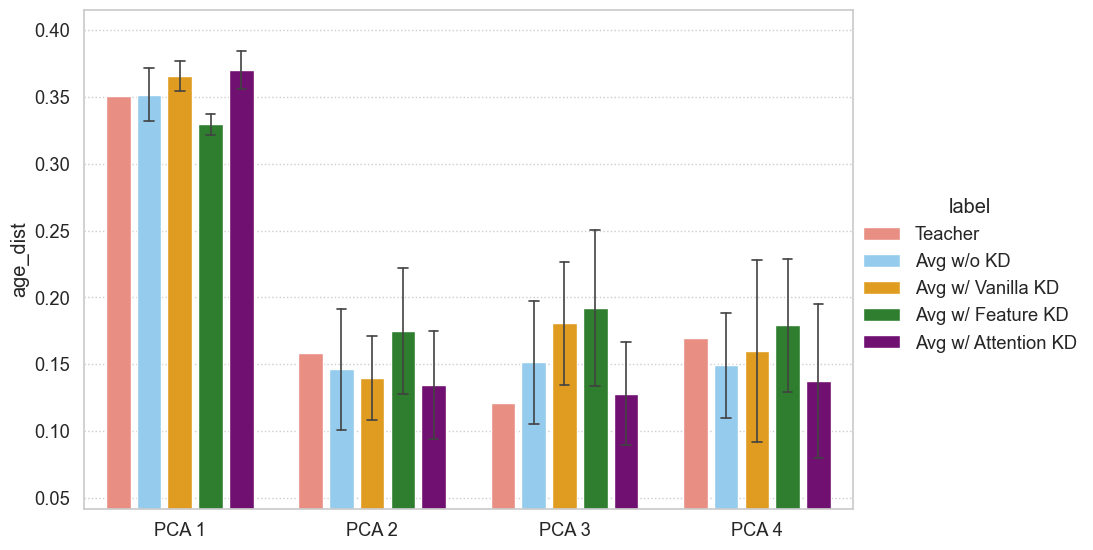

In [28]:
# TODO: Can do each dataset seperetely

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    student_attention,
    metric='label_dist',
)

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    student_attention,
    metric='sex_dist'
)

plot_similarity_grouped_barplot(
    teacher_df,
    student_df,
    student_feature,
    student_attention,
    metric='age_dist'
)